# Plots for npe

In [1]:
# magic command to reload modules
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import sys
import yaml
from sbi import analysis
import os
from scipy.stats import gaussian_kde
from tqdm import tqdm

NSC_DIR = Path(os.getcwd()).resolve().parent.parent.as_posix()  # NSC dir
sys.path.append(f"{NSC_DIR}/codes/src")
from utils.setup import adapt_path
from utils.event import get_train_valid_lr
from utils.plots import load_img, pairplot, plot_posterior_mapped_samples, marginal_plot
from utils.inference import (
    get_posterior,
    load_stored_config,
    sampling_from_posterior,
    ci_perf_on_dset,
    perfs_on_dset,
)
from utils.train import WarmupScheduler, plot_posterior_with_label, load_net, get_limits
from simulator.model_sim_pR import DM_sim_for_seqCs_parallel_with_smaller_output
from utils.range import x2seqC, seqC2x, convert_samples_range
from utils.set_seed import setup_seed

import matplotlib as mpl
import matplotlib.pyplot as plt

# remove top and right axis from plots
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
# remove all edges

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE, weight='bold')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mpl.rcParams["axes.edgecolor"] = "k"
mpl.rcParams["axes.linewidth"] = 2

font = {"weight": "bold"}
mpl.rc("font", **font)

# grid alpha to 0.2
mpl.rcParams["grid.alpha"] = 0.2

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown"]
from features.features import *

src/username/data/NSC/data/dataset_L0_exp_set_0.h5


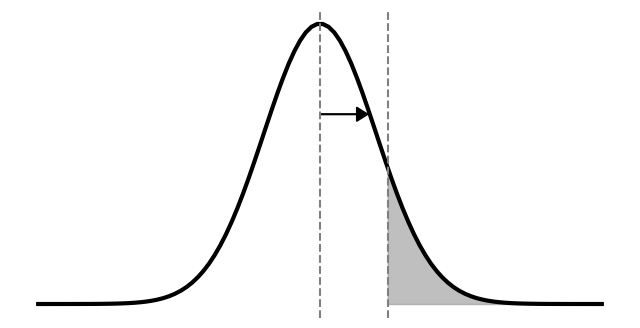

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

font = {
    "weight": "bold",
    "size": 12,
}
mpl.rc("font", **font)

mean = 0
var = 1
# Generate some data
np.random.seed(0)
data = np.random.randn(1000)

# Calculate the PDF over a range of values
x = np.linspace(-5, 5, 100)
y = norm.pdf(x, mean, var)  # mean=0, std=1

# Create a new figure and set the facecolor to none (transparent)
fig = plt.figure(facecolor="none", figsize=(8, 4))
ax = fig.add_subplot(111)

# Plot the Gaussian distribution curve
ax.plot(x, y, "k", linewidth=3)

# Draw a vertical line at x = 1
ax.axvline(x=1.2, color="gray", linestyle="--")
ax.axvline(x=0, color="gray", linestyle="--")

# Fill the area under the curve for x > 1
x_fill = np.linspace(1.2, 5, 100)
y_fill = norm.pdf(x_fill, mean, var)
ax.fill_between(x_fill, y_fill, color="gray", alpha=0.5)

# draw a bi-directional arrow from x=0 to x=1

# annotate the sigma values
# ax.annotate(
#     "$\mathbf{\sigma^2}$",
#     xy=(0.5, 0.1),
#     xytext=(0, 0.285),
# )
ax.arrow(0, 0.27, 0.65, 0, head_width=0.02, head_length=0.2, fc="k", ec="k")


# Remove the background
ax.set_facecolor("none")
# remove the ticks
ax.tick_params(axis="both", which="both", length=0)
# set x=0 with x tick label a
ax.set_xticks([0, 1])
# ax.set_xticklabels([r"$\mathbf{\mu}$", "b"])

# Hide the axis labels and grid
ax.set_yticklabels([])
ax.grid(False)

ax.set_axis_off()
# Show the plot
plt.show()

## load data

In [3]:
# %% ==================================================
pipeline_version = "p5a"
train_id = "train_L0_p5a"
exp_id = "p5a-conv_lstm-corr_conv"
log_exp_id = "npe-conv_lstm-mdn"
# log_exp_id = "npe-conv_lstm-maf3"

# %% ========== load the latest event file
log_dir = Path(NSC_DIR) / "codes/src/train/logs" / train_id / exp_id
(
    wall_time,
    step_nums,
    learning_rates,
    log_probs_train,
    log_probs_valid,
) = get_train_valid_lr(log_dir)

all_probs = np.concatenate([log_probs_train, log_probs_valid])
upper = np.max(all_probs)
lower = np.percentile(all_probs, 10)

# %% ========== load the config.yaml file
config_file = log_dir / "config.yaml"
config = adapt_path(config_file)

with open(config, "r") as f:
    config = yaml.safe_load(f)

prior_min = config["prior"]["prior_min"]
prior_max = config["prior"]["prior_max"]
# prior_labels = config["prior"]["prior_labels"]
prior_labels = ["$b$", "$\sigma^2_a$", "$\sigma^2_s$", "$\lambda$"]
fig_dir = Path(f"{NSC_DIR}/codes/notebook/figures/")

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['train_loss_batch', 'learning_rates'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['log_probs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['log_probs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


## Training curve

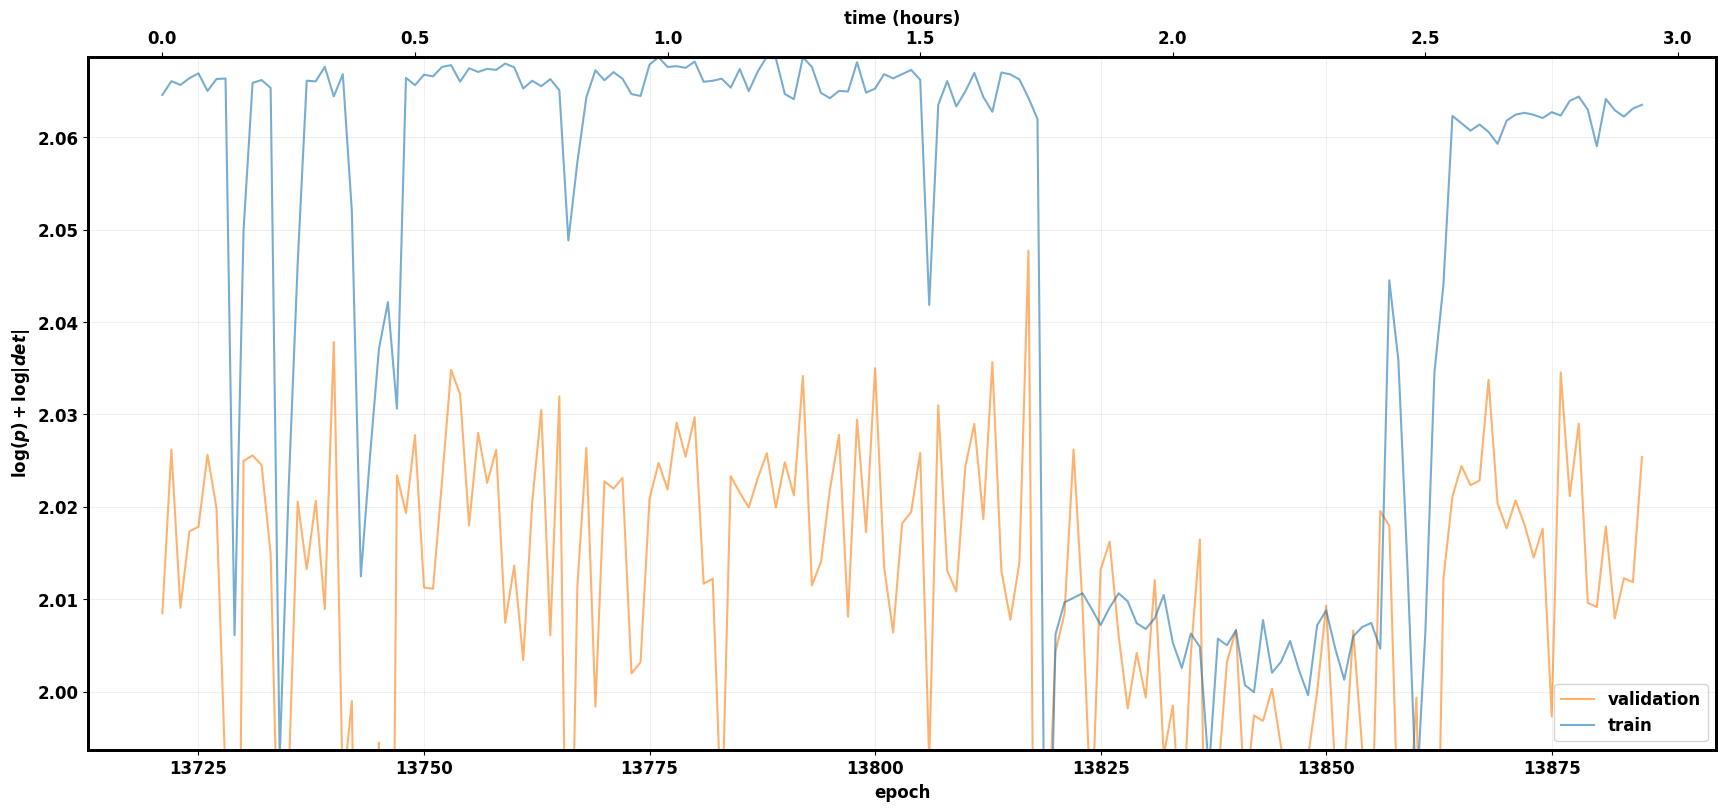

In [5]:
# %% ========== plot training curves
fig, ax = plt.subplots(figsize=(21, 9))
ax.plot(step_nums, log_probs_valid, label="validation", alpha=0.6, ms=0.2, color=colors[1])
ax.plot(step_nums, log_probs_train, label="train", alpha=0.6, ms=0.2, color=colors[0])
ax.set_ylim(lower, upper)
ax.set_xlabel("epoch")
ax.set_ylabel("$\log(p)+\log|det|$")
ax.grid(alpha=0.2)
ax.legend()

ax1 = ax.twiny()
ax1.plot(
    (np.array(wall_time) - wall_time[0]) / 60 / 60,
    max(log_probs_valid) * np.ones_like(log_probs_valid),
    "-",
    alpha=0,
)
ax1.set_xlabel("time (hours)")

save_fig = fig_dir / 'npe' / f'{log_exp_id}-training-curve.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## Training progress

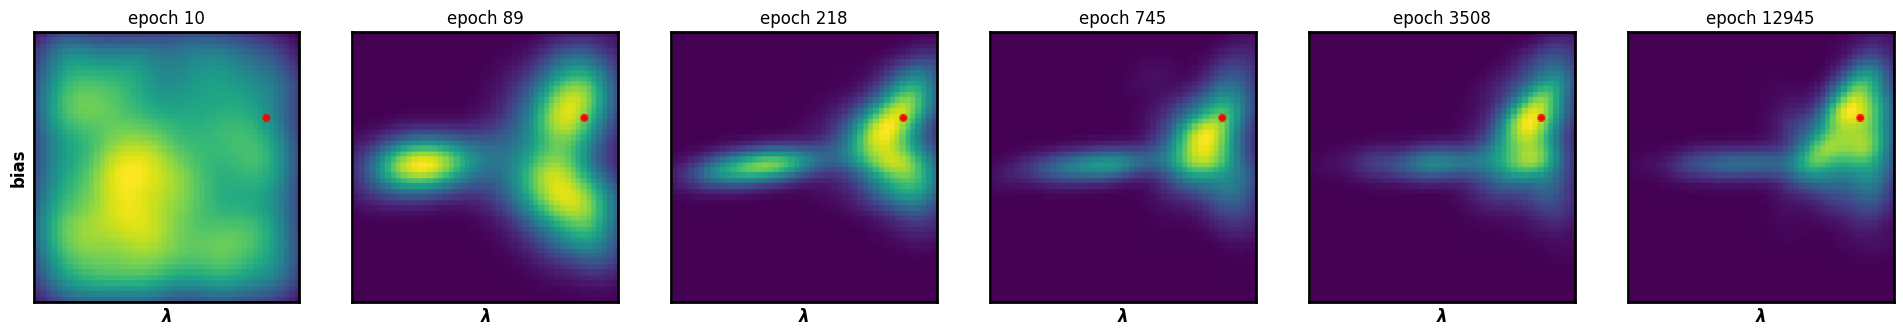

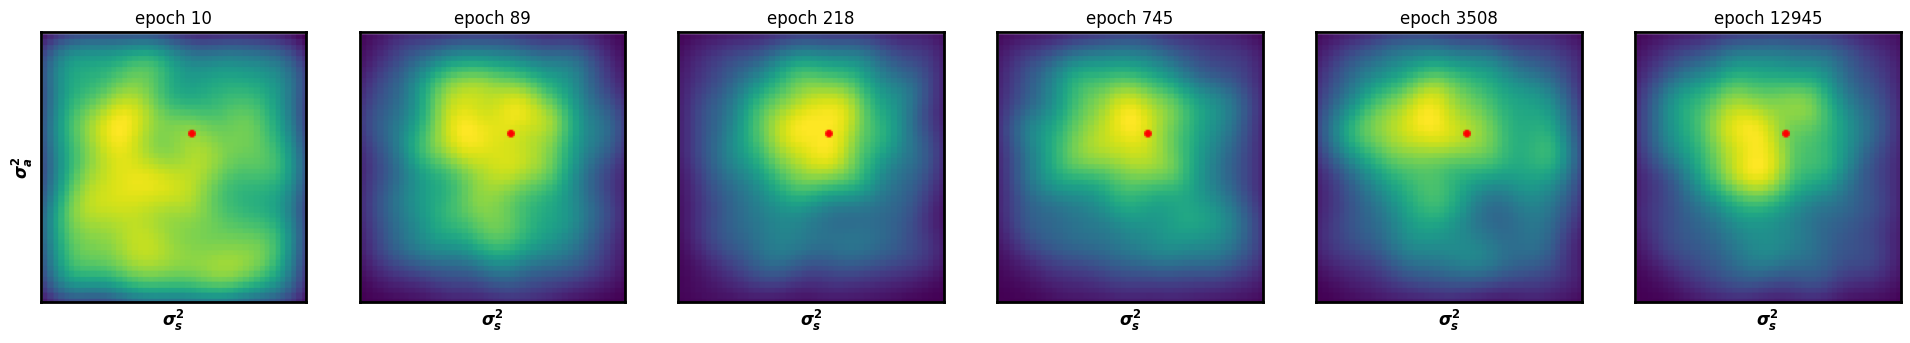

In [6]:
# %% ========== plot posterior training process
num_epoch = 6
best_epoch = step_nums[np.argmax(log_probs_valid)]

# get recorded posterior plot names
img_folder = Path(f"{log_dir}/posterior/figures")
posterior_plots = img_folder.glob("posterior_seen_0*.png")
posterior_idx = [eval(str(plot).split("epoch_")[-1].split(".png")[0]) for plot in posterior_plots]
posterior_idx = np.array(posterior_idx)[np.argsort(posterior_idx)]

chosen_idx = np.linspace(10, len(posterior_idx) - 1, num_epoch, dtype=int)

BL_coor = [731, 731 + 170, 99, 99 + 173]  # x_start, x_end, y_start, y_end
BL_labels = ["$\lambda$", "bias"]
AS_coor = [528, 528 + 170, 304, 304 + 173]  # x_start, x_end, y_start, y_end
AS_labels = ["$\sigma^2_s$", "$\sigma^2_a$"]

coor = BL_coor
labels = BL_labels

# coor = AS_coor
# labels = AS_labels
fig, axes = plt.subplots(1, num_epoch, figsize=(num_epoch * 4, 4))
for i, epoch_idx in enumerate(chosen_idx):
    ax = axes[i]
    img_path = img_folder / f"posterior_seen_0_epoch_{posterior_idx[epoch_idx]}.png"
    if img_path.exists():
        load_img(
            img_path=img_path,
            ax=ax,
            title=f"epoch {posterior_idx[epoch_idx]}",
            crop=True,
            x_start=coor[0],
            x_end=coor[1],
            y_start=coor[2],
            y_end=coor[3],
        )
    ax.set_xlabel(labels[0])
    if i == 0:
        ax.set_ylabel(labels[1])

save_fig = fig_dir / 'npe' / f'{log_exp_id}-train-progress-BL0.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

coor = AS_coor
labels = AS_labels
fig, axes = plt.subplots(1, num_epoch, figsize=(num_epoch * 4, 4))
for i, epoch_idx in enumerate(chosen_idx):
    ax = axes[i]
    img_path = img_folder / f"posterior_seen_0_epoch_{posterior_idx[epoch_idx]}.png"
    if img_path.exists():
        load_img(
            img_path=img_path,
            ax=ax,
            title=f"epoch {posterior_idx[epoch_idx]}",
            crop=True,
            x_start=coor[0],
            x_end=coor[1],
            y_start=coor[2],
            y_end=coor[3],
        )
    ax.set_xlabel(labels[0])
    if i == 0:
        ax.set_ylabel(labels[1])
        
save_fig = fig_dir / 'npe' / f'{log_exp_id}-train-progress-sigmas.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## Load posterior samples 

In [4]:
# %% ==========  get posterior samples
config, model_path = load_stored_config(exp_dir=log_dir)

if "p4" in pipeline_version:
    from train.train_L0_p4a import Solver
if "p5" in pipeline_version:
    from train.train_L0_p5a import Solver

solver, posterior, train_loader, valid_loader, train_dataset, valid_dataset = get_posterior(
    model_path=model_path,
    config=config,
    device="cuda",
    Solver=Solver,
    low_batch=20,
    return_dataset=True,
)

==>> config_path: /home/wehe/data/NSC/codes/src/train/logs/train_L0_p5a/p5a-conv_lstm-corr_conv/config.yaml
using device: cuda

--- CUDA info ---
NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
--- CUDA info ---



/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


prior min before norm: [-2.5, 0, 0, -11]
prior max before norm: [2.5, 77, 18, 10]
prior min: [0. 0. 0. 0.]
prior max: [1. 1. 1. 1.]

=== embedding net === 
conv_lstm

=== train, val dataset and dataloader ===
train_set_names=['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24']
valid_set_names=['set_25', 'set_26']
[training] sets Loading 18 dataset into memory... 
['set_0', 'set_1', 'set_10', 'set_11', 'set_12', 'set_13', 'set_14', 'set_15', 'set_16', 'set_17', 'set_18', 'set_19', 'set_2', 'set_20', 'set_21', 'set_22', 'set_23', 'set_24'] ... 0 2 4 6 8 10 12 14 16  finished in: 0.57s
dur of [3, 9, 15] are chosen, others are [removed] 
[seqC] shape: (18, 3, 3, 700, 15)
[theta] shape: (18, 500, 4)
[probR] shape: (18, 3, 3, 700, 500, 1)
==>> Further Sampling 20 times from probR (given 'in_dataset' process setting) ... in 0.03min
sampled chR shape torch.Size([18, 9, 7

In [5]:
normed_limits = solver._get_limits()
designed_limits = get_limits(config.prior.prior_min, config.prior.prior_max)

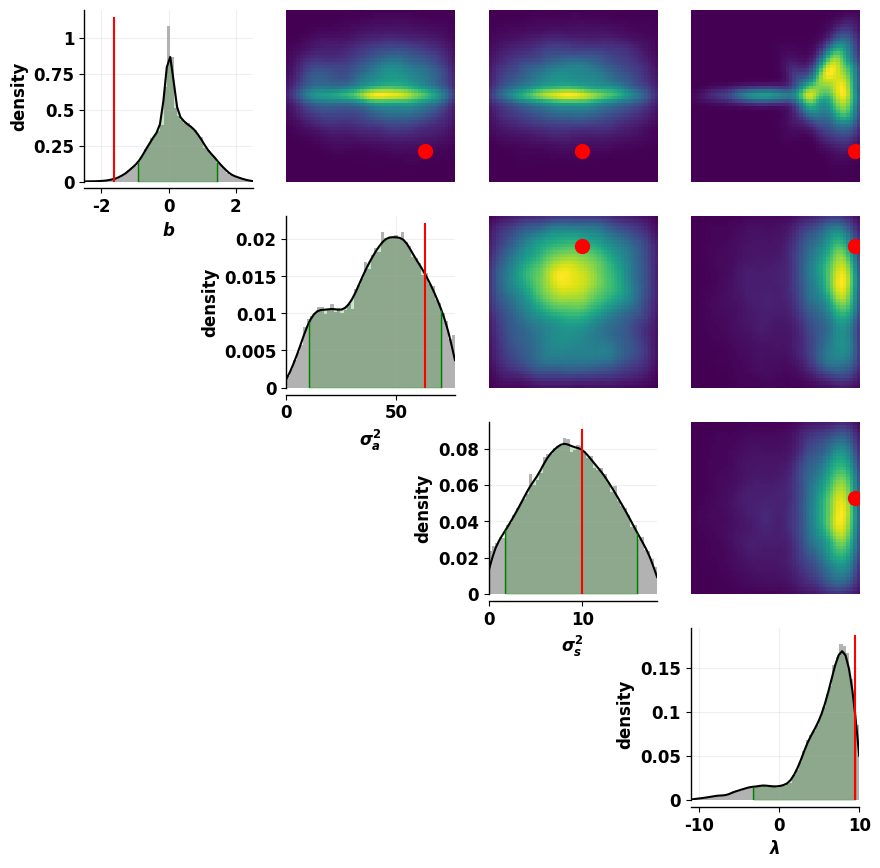

In [9]:
# %% load one sample - training sample
# seen_data = solver.inference.seen_data_for_posterior
# xy_o, true_theta = seen_data["x"][1], seen_data["theta"][1]
xy_o, true_theta = train_dataset[100]

fig, ax, samples = plot_posterior_mapped_samples(
    posterior,
    xy_o,
    true_theta=true_theta,
    num_samples=20_000,
    sampling_device="cuda",
    show_progress_bars=False,
    original_limits=normed_limits,
    mapped_limits=designed_limits,
)

save_fig = fig_dir / 'npe' / f'{log_exp_id}-train-posterior.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

# xy_o, true_theta = valid_dataset[0]

# fig, ax, samples = plot_posterior_mapped_samples(
#     posterior,
#     xy_o,
#     true_theta=true_theta,
#     num_samples=20_000,
#     sampling_device="cuda",
#     show_progress_bars=False,
#     original_limits=normed_limits,
#     mapped_limits=designed_limits,
# )

# save_fig = fig_dir / 'npe' / f'{log_exp_id}-valid-posterior.png'
# fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

In [8]:
xy_o.shape

torch.Size([6300, 16])

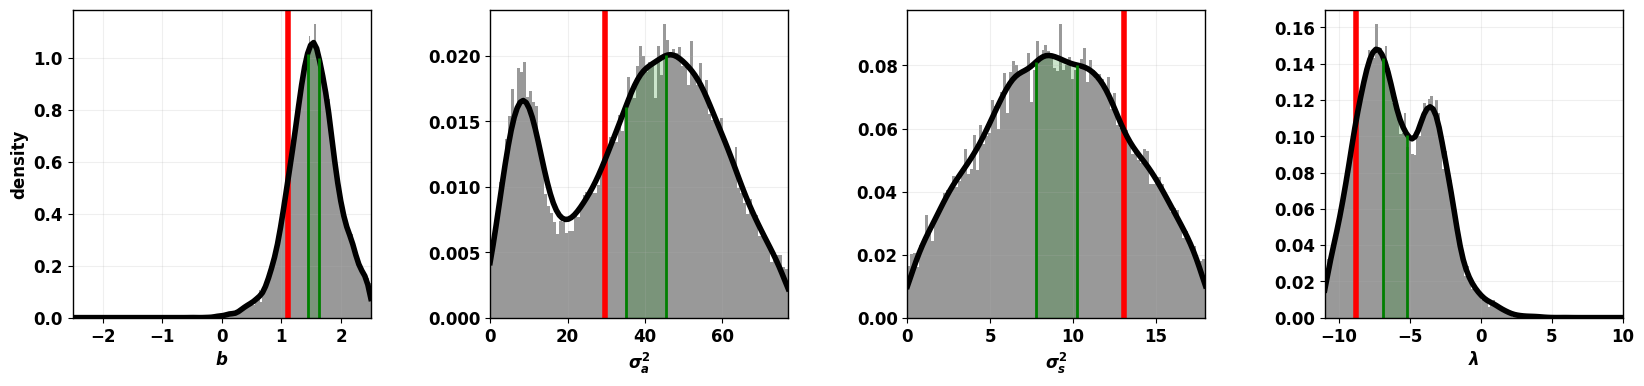

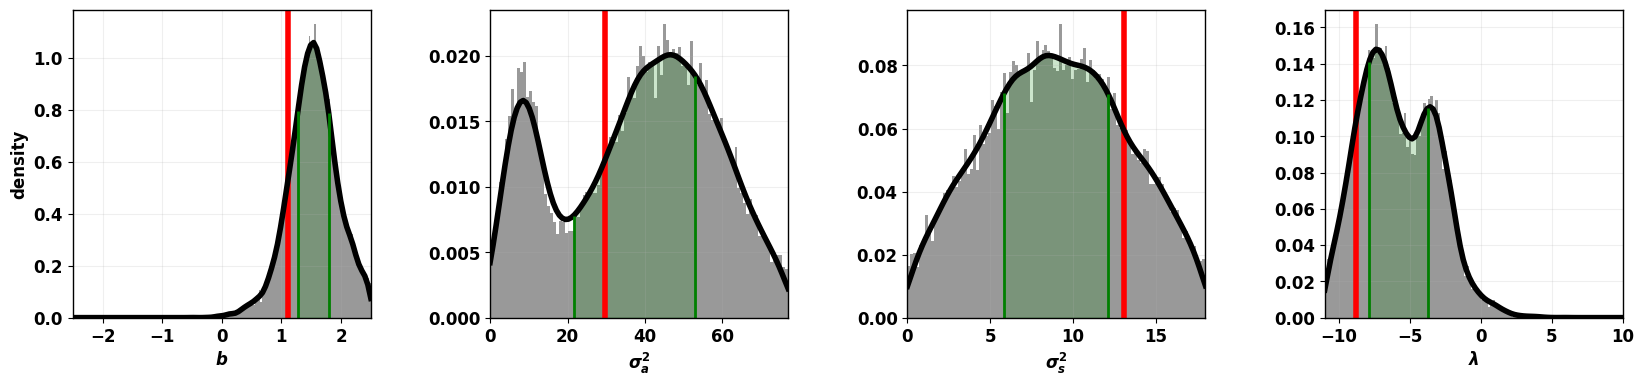

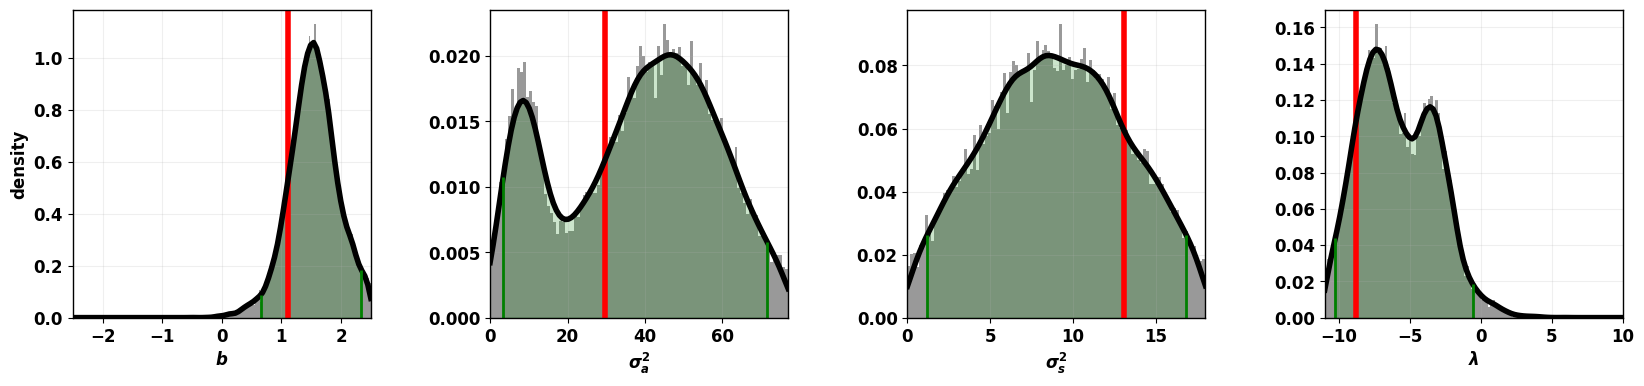

In [13]:
# xy_o, true_theta = train_dataset[0]

credible_intervals = [20, 50, 95]
for credible_interval in credible_intervals:
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    fig.subplots_adjust(wspace=0.4)
    true_theta_dr = convert_samples_range(true_theta, normed_limits, designed_limits)
    axes = marginal_plot(
        samples,
        true_theta_dr,
        origin_limits=designed_limits,
        dest_limits=designed_limits,
        credible_interval=credible_interval,
        axes=axes,
    )
    for i in range(len(axes)):
        axes[i].set_xlabel(prior_labels[i])
        
    save_fig = fig_dir / 'npe' / f'{log_exp_id}-margin-ci{credible_interval}.png'
    fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## [Model] sensitivity index

In [56]:
model_name = 'B-G-L0S-O-N-'

from simulator.DM_model import DM_model
from simulator.seqC_generator import seqC_generator
import numpy as np
import matplotlib.pyplot as plt

from SALib.sample import saltelli
from SALib.analyze import sobol
from scipy.stats import spearmanr
import numpy as np

def model(params):
    model = DM_model(params=params, model_name=model_name)
    a, probR = model.simulate(seqC)
    return probR


def compute_Si_corr(problem, nsample=2000):
    # generate samples
    param_values = saltelli.sample(problem, nsample)

    # calculate model output for the sampled parameter sets
    Y = np.zeros([param_values.shape[0]])
    for i, X in enumerate(param_values):
        Y[i] = model(X)

    # perform the sensitivity analysis
    Si = sobol.analyze(problem, Y, print_to_console=False)

    # print the first-order sensitivity indices
    for name, s1 in zip(problem['names'], Si['S1']):
        print(f'Sensitivity index for {name}: {s1}')
    print('Total sensitivity indices: ', Si['ST'])
    print('Second-order sensitivity indices: ', Si['S2'])

    # calculate correlation among parameters
    corr, _ = spearmanr(param_values)
    # print('Spearman correlation: \n', corr)
    
    return Si, corr

def plot_Si(Si, problem):
    # plot the sensitivity indices
    fig, axs = plt.subplots(1, 3, figsize=(20, 4))
    ax = axs[0]
    ax.bar(problem['names'], Si['S1'], color='k')
    ax.set_ylabel('Index value')
    ax.set_ylim(0,1)
    ax.grid(alpha=0.3)
    ax.set_title('$S_1$ index')

    ax = axs[1]
    ax.bar(problem['names'], Si['ST'], color='k')
    ax.set_ylim(0,1)
    ax.grid(alpha=0.3)
    ax.set_title('$S_T$ index')
    
    ax = axs[2]
    im = ax.imshow(Si['S2'], cmap='Greys', vmin=0, vmax=0.5)
    ax.set_xticks(np.arange(len(problem['names'])))
    ax.set_yticks(np.arange(len(problem['names'])))
    ax.set_xticklabels(problem['names'])
    ax.set_yticklabels(problem['names'])
    ax.set_title('$S_2$ index')
    fig.colorbar(im, ax=ax)
    return fig

In [57]:
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[9],
    MS_list=[0.4],
    seqC_sample_per_MS=1,
)

problem = {
    'num_vars': 4,
    'names': ['$b$', '$\sigma^2_a$', '$\sigma^2_s$', '$\lambda$'],
    'bounds': [[-2.5, 2.5],
               [   0,  77],
               [   0,  18],
               [ -11,  10]],
}

Si, corr = compute_Si_corr(problem)

# problem_2 = {
#     'num_vars': 4,
#     'names': ['bias', 'sigma2a', 'sigma2s', 'L0'],
#     'bounds': [[-0.6, 0.2],
#                [   0,  13],
#                [   0,   5],
#                [-1.2, 1.8]],
# }

# Si_2, corr_2 = compute_Si_corr(problem_2)
# plot_Si(Si_2, problem_2)


--- generated seqC info ---
dur_list: [9]
MS_list: [0.4]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)


/tmp/ipykernel_583382/3695870804.py:21: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, nsample)


Sensitivity index for $b$: 0.5061654486622064
Sensitivity index for $\sigma^2_a$: -0.012036450385236423
Sensitivity index for $\sigma^2_s$: -4.5123107503471885e-05
Sensitivity index for $\lambda$: -0.0018485467608020992
Total sensitivity indices:  [9.96062848e-01 7.38734944e-02 7.35002668e-06 4.55596155e-01]
Second-order sensitivity indices:  [[            nan  5.15708531e-02 -3.81446222e-03  4.27135597e-01]
 [            nan             nan  1.27956735e-02  1.67264928e-02]
 [            nan             nan             nan  1.08556231e-04]
 [            nan             nan             nan             nan]]


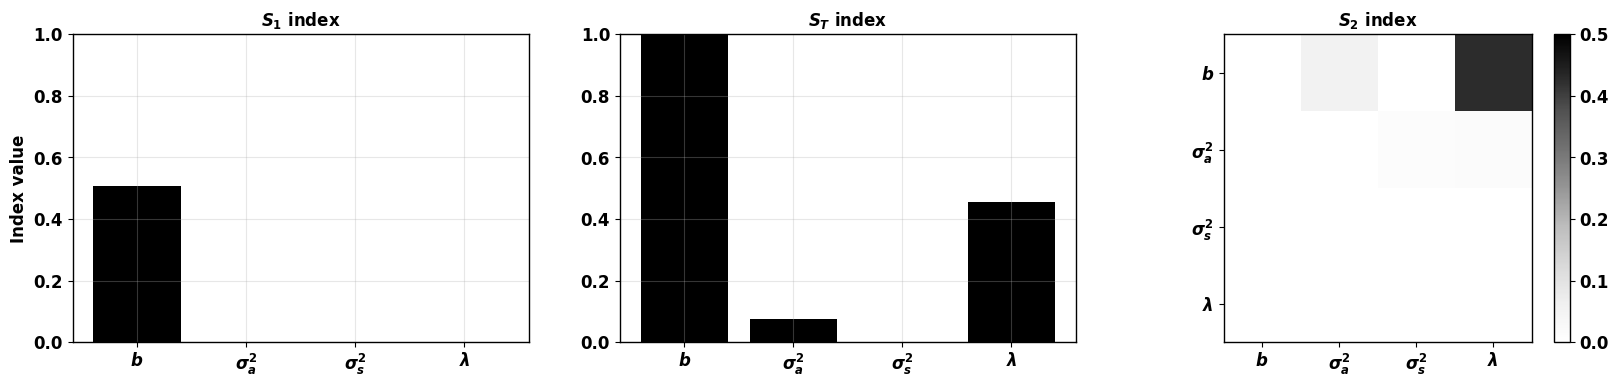

In [58]:
fig = plot_Si(Si, problem)
save_fig = fig_dir / 'npe' / 'sensitivity index.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

## [Qualitative] change one of the parameter and see how the prediction changes

In [16]:
# prepare varying theta values
print(f"{designed_limits=}")
ref_theta_values = [1, 10, 10, 1]

step = 7
theta_values = np.ones((4 * step, 4))
for i in range(len(ref_theta_values)):
    theta_values[:, i] = ref_theta_values[i]

for i, limits in enumerate(designed_limits):
    values = np.linspace(limits[0], limits[1], step)
    theta_values[i * step : (i + 1) * step, i] = values

print(f"==>> theta_values: {theta_values}")    

designed_limits=[[-2.5, 2.5], [0, 77], [0, 18], [-11, 10]]
==>> theta_values: [[ -2.5         10.          10.           1.        ]
 [ -1.66666667  10.          10.           1.        ]
 [ -0.83333333  10.          10.           1.        ]
 [  0.          10.          10.           1.        ]
 [  0.83333333  10.          10.           1.        ]
 [  1.66666667  10.          10.           1.        ]
 [  2.5         10.          10.           1.        ]
 [  1.           0.          10.           1.        ]
 [  1.          12.83333333  10.           1.        ]
 [  1.          25.66666667  10.           1.        ]
 [  1.          38.5         10.           1.        ]
 [  1.          51.33333333  10.           1.        ]
 [  1.          64.16666667  10.           1.        ]
 [  1.          77.          10.           1.        ]
 [  1.          10.           0.           1.        ]
 [  1.          10.           3.           1.        ]
 [  1.          10.           6.          

In [20]:
# prepare the seqC_o
x_o = xy_o[:, :-1]
seqC_o = x2seqC(x_o).unsqueeze(1).unsqueeze(1)
print(f"==>> x_o.shape: {x_o.shape}")
print(f"==>> seqC_o.shape: {seqC_o.shape}")
print(f'{seqC_o[:5,0,0,:]=}')

==>> x_o.shape: torch.Size([6300, 15])
==>> seqC_o.shape: torch.Size([6300, 1, 1, 15])
seqC_o[:5,0,0,:]=tensor([[ 0.0000,  0.0000,  0.2000,     nan,     nan,     nan,     nan,     nan,
             nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [ 0.0000, -0.8000, -0.8000,  0.8000,  0.0000, -0.8000,  0.8000,  0.8000,
          0.0000,     nan,     nan,     nan,     nan,     nan,     nan],
        [ 0.0000, -0.8000,  0.8000,     nan,     nan,     nan,     nan,     nan,
             nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [ 0.0000, -0.8000, -0.8000,     nan,     nan,     nan,     nan,     nan,
             nan,     nan,     nan,     nan,     nan,     nan,     nan],
        [ 0.0000, -0.4000,  0.0000,  0.0000, -0.4000,  0.4000,  0.4000,  0.4000,
          0.0000,     nan,     nan,     nan,     nan,     nan,     nan]])


In [17]:
# run the simulator
params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
    seqCs=seqC_o,
    prior=theta_values,
    num_workers=16,
    privided_prior=True,
)

==>> x_o.shape: torch.Size([6300, 15])
==>> seqC_o.shape: torch.Size([6300, 1, 1, 15])

--- simulating pR with... ---
prior sample size: 1
model_name: B-G-L0S-O-N-
total number of simulations 176400 with 16 workers ...



/tmp/ipykernel_18183/667131930.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=16)]: Done 640 tasks      | elapsed:    4.9s
[Parallel(n_jobs=16)]: Done 4640 tasks      | elapsed:    7.6s
[Parallel(n_jobs=16)]: Done 10240 tasks      | elapsed:   11.1s
[Parallel(n_jobs=16)]: Done 17440 tasks      | elapsed:   15.7s
[Parallel(n_jobs=16)]: Done 26240 tasks      | elapsed:   21.1s
[Parallel(n_jobs=16)]: Done 36640 tasks      | elapsed:   27.5s
[Parallel(n_jobs=16)]: Done 48640 tasks      | elapsed:   34.9s
[Parallel(n_jobs=16)]: Done 62240 tasks      | elapsed:   42.9s
[Parallel(n_jobs=16)]: Done 77440 tasks      | elapsed:   52.4s
[Parallel(n_jobs=16)]: Done 94240 tasks      | elapsed:  1.0m

time elapsed for simulation: 1.89 minutes
stacking the results
done stacking the results

seqC.shape: torch.Size([6300, 1, 1, 15]), params.shape: (28, 4), probR.shape: (6300, 1, 1, 28, 1)


[Parallel(n_jobs=16)]: Done 176400 out of 176400 | elapsed:  1.9min finished


In [25]:
# save the results
valid_data_dir = f"{fig_dir}/npe/{log_exp_id}-dataset_validation.npz"
np.savez(
    valid_data_dir,
    seqC_o=seqC_o,
    theta_values=theta_values,
    params=params,
    probR=probR,
)

load test data

In [12]:
step = 7
# %% load the results
valid_data_dir = f"{fig_dir}/npe/{log_exp_id}-dataset_validation.npz"
dataset = np.load(valid_data_dir)
seqC_o = dataset["seqC_o"]
theta_values = dataset["theta_values"]
params = dataset["params"]
probR = dataset["probR"]

probR = probR.squeeze(1).squeeze(1)

print(f"==>> seqC_o.shape: {seqC_o.shape}")
print(f"==>> probR.shape: {probR.shape}")

# bernoulli sampling using pytorch
probR = torch.from_numpy(probR).float()
chR = probR.repeat_interleave(10, dim=-1)
chR = torch.bernoulli(chR)
print(f"==>> chR.shape: {chR.shape}")


# %% plot the results
x_o = torch.from_numpy(seqC2x(seqC_o).squeeze(1).squeeze(1))
print(f"==>> x_o.shape: {x_o.shape}")

==>> seqC_o.shape: (6300, 1, 1, 15)
==>> probR.shape: (6300, 28, 1)
==>> chR.shape: torch.Size([6300, 28, 10])
==>> x_o.shape: torch.Size([6300, 15])


/home/wehe/data/NSC/codes/src/utils/range.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples = torch.tensor(samples, dtype=torch.float32)


theta_test=tensor([0.0000, 0.1299, 0.5556, 0.5714])


/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/pyknos/mdn/mdn.py:283: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2191.)
  zero_mean_samples, 

theta_test=tensor([0.1667, 0.1299, 0.5556, 0.5714])


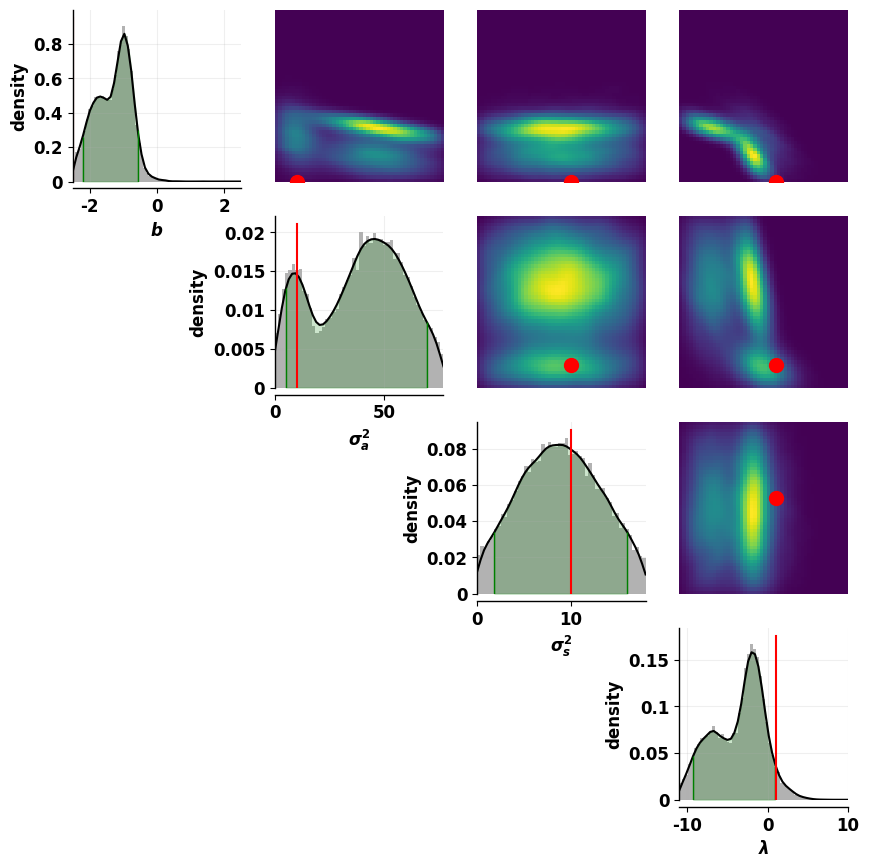

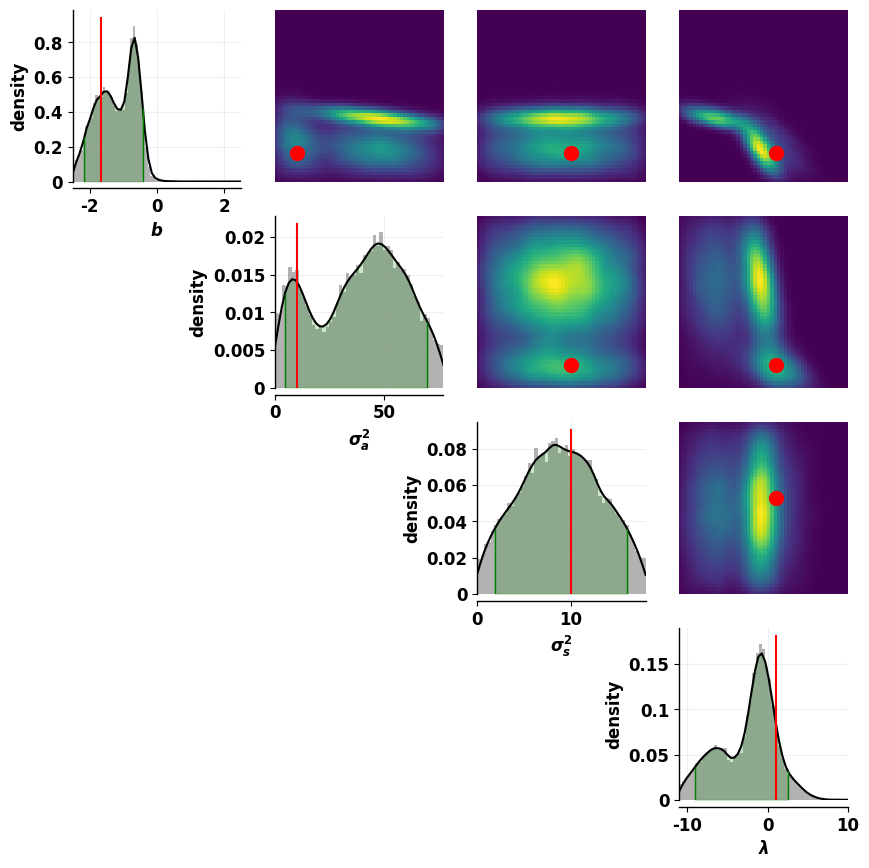

In [14]:
# T = 0
C = 0
# for T in range(20):

for T in range(2):
    theta_test = torch.tensor(theta_values[T, :])
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    chR_test = chR[:, T, C].unsqueeze(-1)
    xy_test = torch.cat([x_o, chR_test], dim=-1)

    print(f"{theta_test=}")

    plot_posterior_mapped_samples(
        posterior,
        xy_test,
        true_theta=theta_test,
        num_samples=20_000,
        sampling_device="cuda",
        show_progress_bars=False,
        original_limits=normed_limits,
        mapped_limits=designed_limits,
    )

In [82]:
C = 0
nT = theta_values.shape[0]
num_params = len(prior_labels)

/home/wehe/data/NSC/codes/src/utils/range.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples = torch.tensor(samples, dtype=torch.float32)
/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


theta_test=tensor([0.1667, 0.1299, 0.5556, 0.5714])
theta_test=tensor([0.3333, 0.1299, 0.5556, 0.5714])
theta_test=tensor([0.5000, 0.1299, 0.5556, 0.5714])
theta_test=tensor([0.6667, 0.1299, 0.5556, 0.5714])
theta_test=tensor([0.8333, 0.1299, 0.5556, 0.5714])
theta_test=tensor([0.7000, 0.1667, 0.5556, 0.5714])
theta_test=tensor([0.7000, 0.3333, 0.5556, 0.5714])
theta_test=tensor([0.7000, 0.5000, 0.5556, 0.5714])
theta_test=tensor([0.7000, 0.6667, 0.5556, 0.5714])
theta_test=tensor([0.7000, 0.8333, 0.5556, 0.5714])
theta_test=tensor([0.7000, 0.1299, 0.1667, 0.5714])
theta_test=tensor([0.7000, 0.1299, 0.3333, 0.5714])
theta_test=tensor([0.7000, 0.1299, 0.5000, 0.5714])
theta_test=tensor([0.7000, 0.1299, 0.6667, 0.5714])
theta_test=tensor([0.7000, 0.1299, 0.8333, 0.5714])
theta_test=tensor([0.7000, 0.1299, 0.5556, 0.1667])
theta_test=tensor([0.7000, 0.1299, 0.5556, 0.3333])
theta_test=tensor([0.7000, 0.1299, 0.5556, 0.5000])
theta_test=tensor([0.7000, 0.1299, 0.5556, 0.6667])
theta_test=t

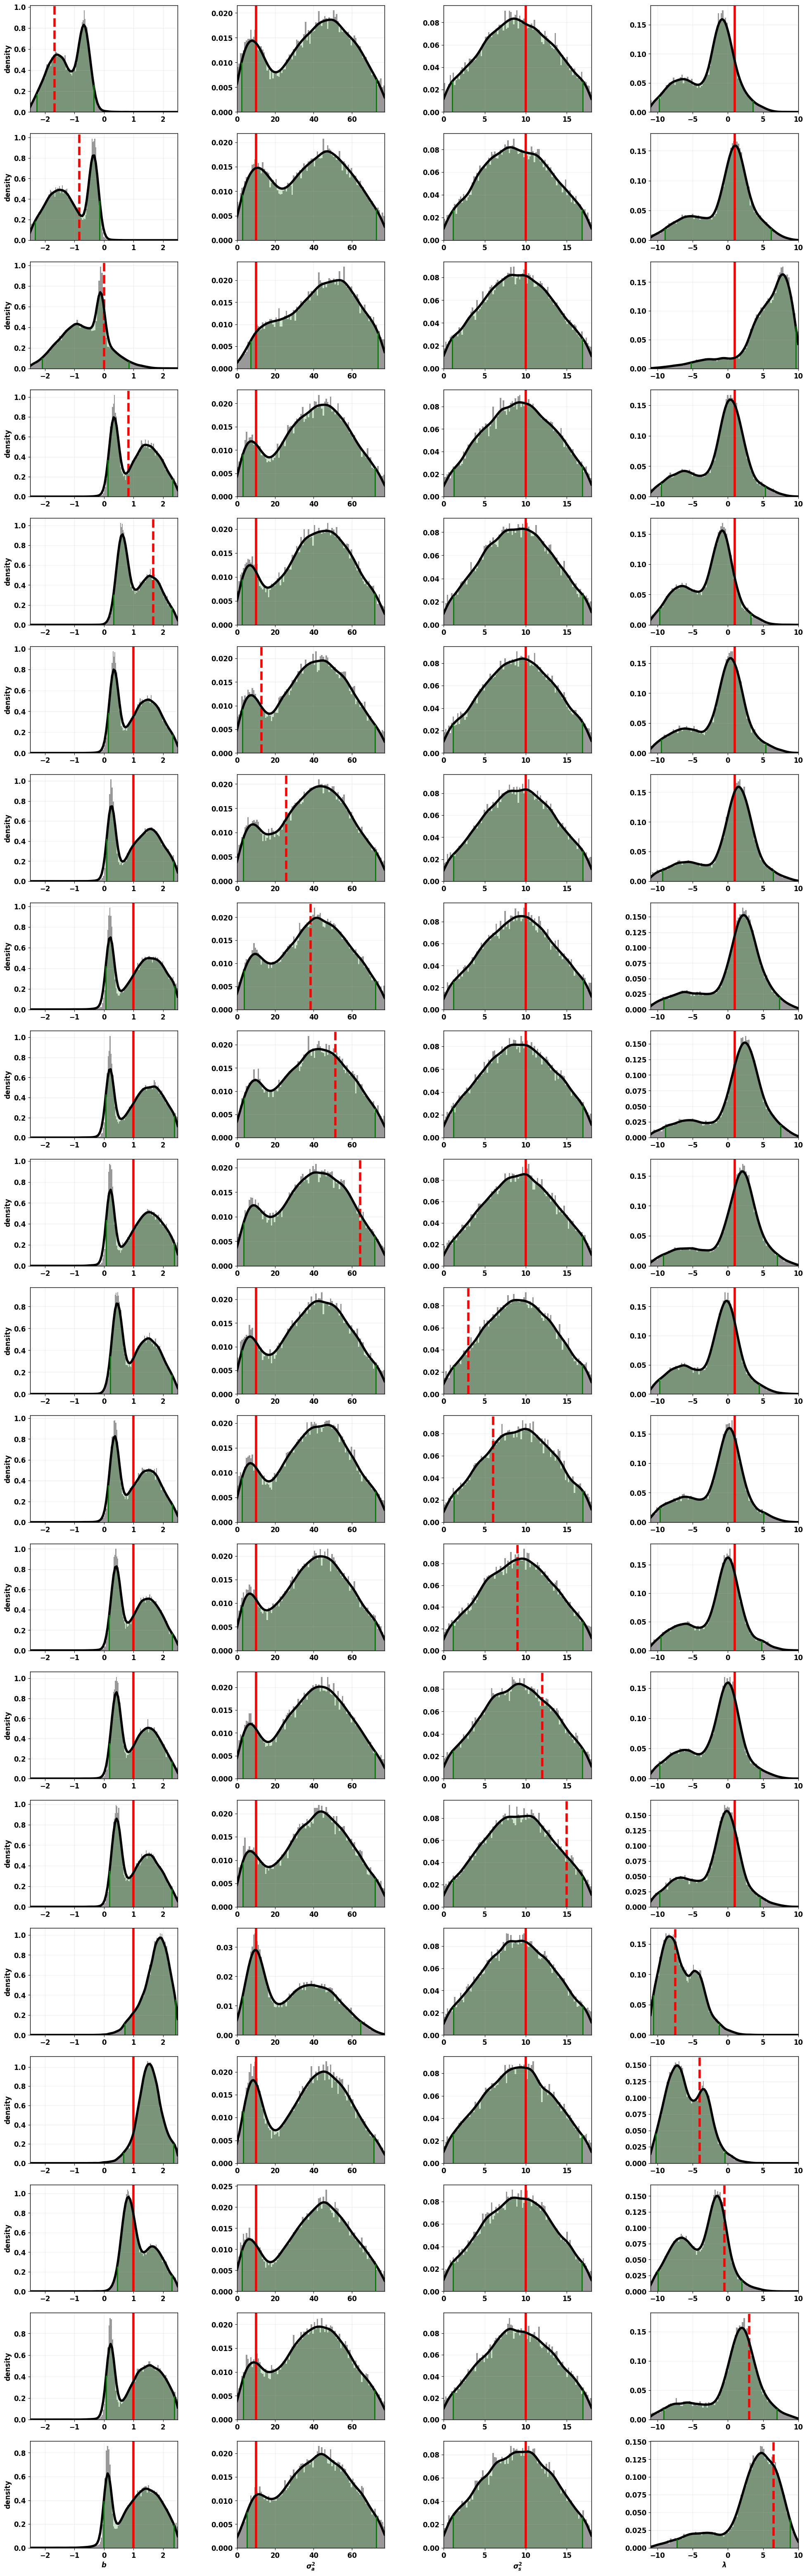

In [16]:
fig, axes = plt.subplots((step - 2) * num_params, 4, figsize=(num_params * 6, 4 * (step - 2) * num_params))

fig.subplots_adjust(wspace=0.4)

counter = 0
for T in range(nT):
    if T % step == 0 or T % step == step - 1:
        continue

    moving_theta_idx = T // step

    theta_test = torch.tensor(theta_values[T, :])
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    chR_test = chR[:, T, C].unsqueeze(-1)
    xy_test = torch.cat([x_o, chR_test], dim=-1)

    print(f"{theta_test=}")

    samples = sampling_from_posterior(
        "cuda",
        posterior,
        xy_test,
        num_samples=20_000,
        show_progress_bars=False,
    )

    ax = marginal_plot(
        samples,
        true_theta=theta_test,
        origin_limits=normed_limits,
        dest_limits=designed_limits,
        moving_theta_idx=moving_theta_idx,
        axes=axes[counter, :],
    )
    counter += 1
    if counter == (step - 2) * num_params:
        for x, label in zip(ax, prior_labels):
            x.set_xlabel(label)

merge into a condensed version

In [77]:
x_o.shape

torch.Size([6300, 15])

In [17]:
nT = theta_values.shape[0]
num_params = len(prior_labels)
all_samples = np.zeros((num_params, step - 2, 20_000, 4))
all_thetas = np.zeros((num_params, step - 2, 4))
C = 0
for T in range(nT):
    if T % step == 0 or T % step == step - 1:
        continue

    moving_theta_idx = T // step
    trial_idx = T % step - 1

    theta_test = torch.tensor(theta_values[T, :])
    theta_test = convert_samples_range(theta_test, designed_limits, normed_limits)
    chR_test = chR[:, T, C].unsqueeze(-1)
    xy_test = torch.cat([x_o, chR_test], dim=-1)

    samples = sampling_from_posterior(
        "cuda",
        posterior,
        xy_test,
        num_samples=20_000,
        show_progress_bars=False,
    )
    all_samples[moving_theta_idx, trial_idx, :, :] = samples
    all_thetas[moving_theta_idx, trial_idx, :] = theta_test

all_samples_dr = convert_samples_range(all_samples, normed_limits, designed_limits)
all_thetas_dr = convert_samples_range(all_thetas, normed_limits, designed_limits)

/home/wehe/data/NSC/codes/src/utils/range.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples = torch.tensor(samples, dtype=torch.float32)
/home/wehe/anaconda3/envs/sbi/lib/python3.10/site-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


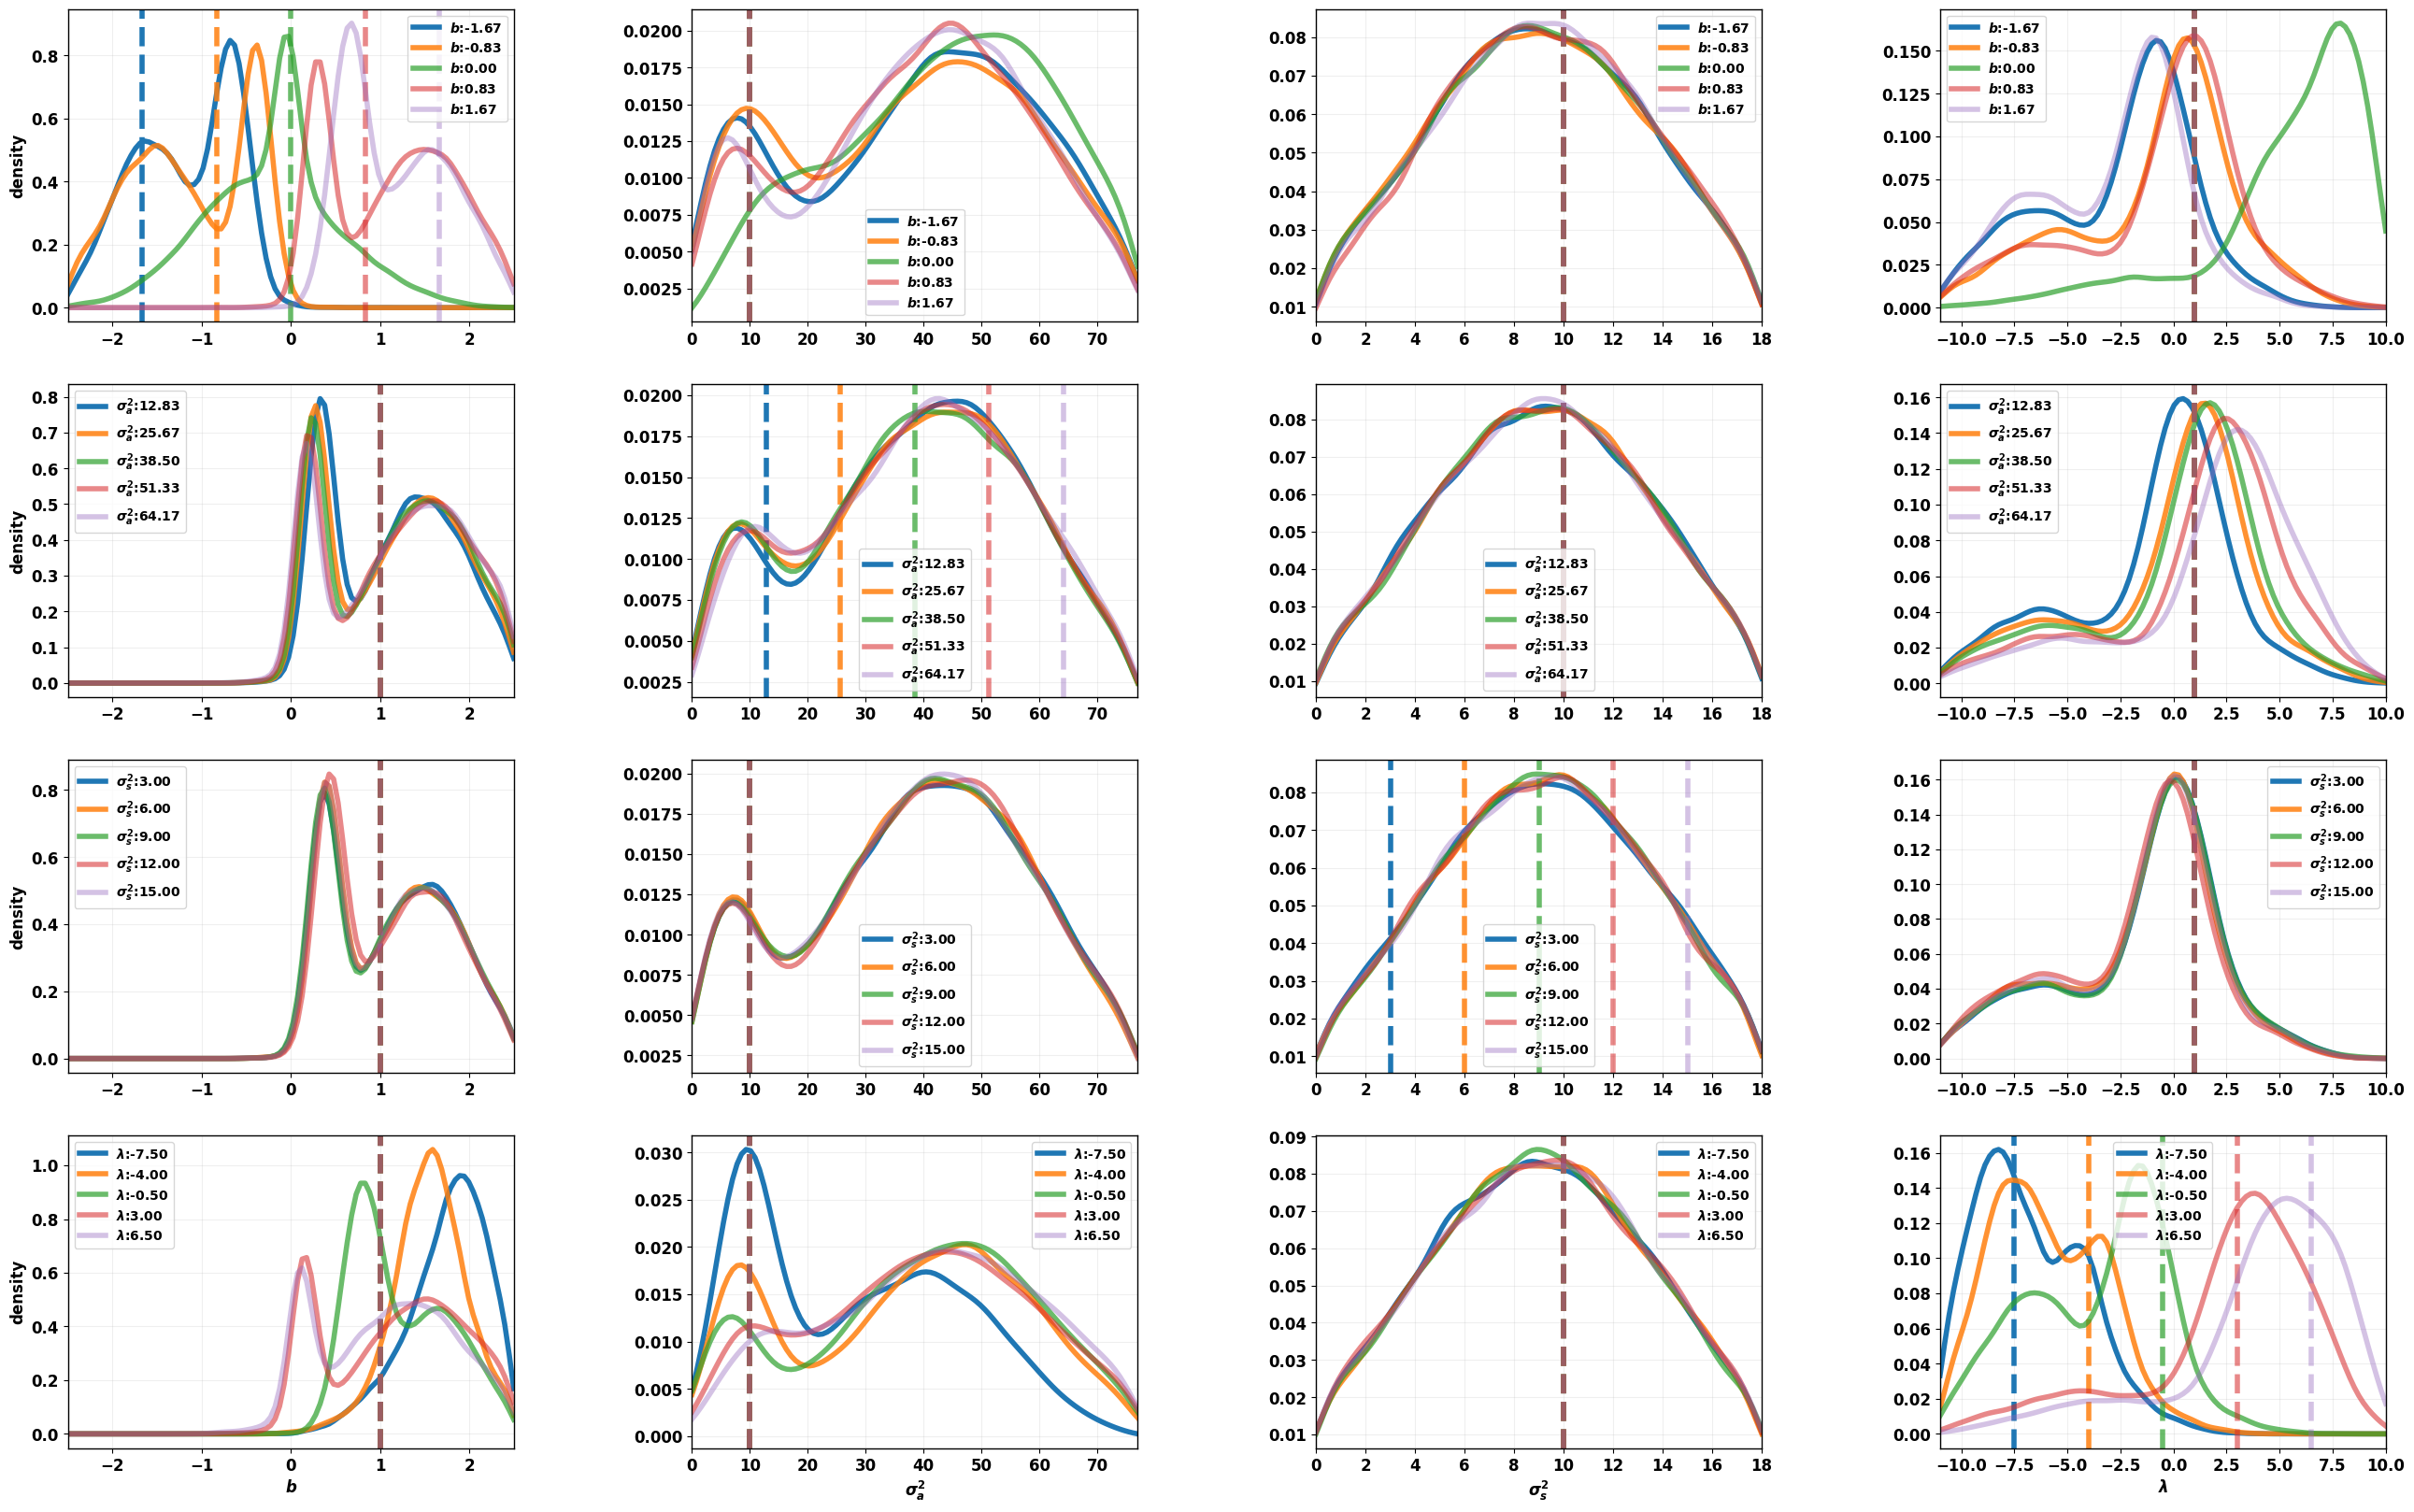

In [18]:
fig, axes = plt.subplots(
    all_thetas_dr.shape[0],
    all_thetas_dr.shape[-1],
    figsize=(all_thetas_dr.shape[-1] * 8, 5 * all_thetas_dr.shape[0]),
)
fig.subplots_adjust(wspace=0.4)
num_trials = all_thetas_dr.shape[1]

dest_limits = designed_limits

for i in range(all_thetas_dr.shape[0]):
    ax_row = axes[i, :]
    samples_row = all_samples_dr[i]
    moving_theta_idx = i

    for j in range(num_params):
        for k in range(num_trials):
            ax = ax_row[j]
            density = gaussian_kde(samples_row[k, :, j], bw_method="scott")
            xs = np.linspace(dest_limits[j][0], dest_limits[j][1], 100)
            ys = density(xs)
            ax.plot(
                xs,
                ys,
                color=colors[k],
                linewidth=4,
                label=f"{prior_labels[i]}:{all_thetas_dr[i, k, i]:.2f}",
                alpha=1 - 0.6 * k / (num_trials - 1),
            )
            ax.set_xlim(dest_limits[j][0], dest_limits[j][1])
            ax.legend(fontsize=10)
            ax.axvline(
                all_thetas_dr[i, k, j],
                color=colors[k],
                linestyle="--",
                linewidth=4,
                alpha=1 - 0.6 * k / (num_trials - 1),
            )
            ax.grid(alpha=0.2)
            if j == 0:
                ax.set_ylabel("density")
        
        if i == num_params-1:
            ax.set_xlabel(prior_labels[j])

save_fig = fig_dir / 'npe' / f'{log_exp_id}-change-of-variables.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

In [91]:
all_samples_dr.shape

torch.Size([4, 5, 20000, 4])

## [test acc] check acc

In [13]:
from utils.inference import estimate_theta_from_post_samples

In [14]:
theta_estimate = np.zeros((all_samples_dr.shape[0], all_samples_dr.shape[1], all_samples_dr.shape[-1]))
for i in range(all_samples_dr.shape[0]):
    for j in tqdm(range(all_samples_dr.shape[1])):
        theta_estimate[i, j, :] = estimate_theta_from_post_samples(dest_limits, all_samples_dr[i,j], mode="mode")

NameError: name 'all_samples_dr' is not defined

In [61]:
all_thetas_dr.shape, theta_estimate.shape

(torch.Size([4, 5, 4]), (4, 5, 4))

In [62]:
all_thetas_dr[0:2,0:2], theta_estimate[0:2,0:2]

(tensor([[[-1.6667, 10.0000, 10.0000,  1.0000],
          [-0.8333, 10.0000, 10.0000,  1.0000]],
 
         [[ 1.0000, 12.8333, 10.0000,  1.0000],
          [ 1.0000, 25.6667, 10.0000,  1.0000]]]),
 array([[[-0.67326931, 44.18487395,  8.5210084 , -0.76470588],
         [-0.39115646, 45.91036415,  9.00360144,  0.61344538]],
 
        [[ 0.34113645, 45.78711485,  9.25570228,  0.41176471],
         [ 0.27310924, 44.18487395,  8.31212485,  1.43697479]]]))

In [69]:
setup_seed(0)
# generate input sequence
seqC = seqC_generator().generate(
    dur_list=[9],
    MS_list=[0.4],
    seqC_sample_per_MS=1,
)
print(f"\n==>> seqC: {seqC}")


--- generated seqC info ---
dur_list: [9]
MS_list: [0.4]
seqC_sample_per_MS: 1
generated seqC shape: (1, 1, 1, 15)

==>> seqC: [[[[0.  0.  0.4 0.  0.  0.  0.  0.  0.4 nan nan nan nan nan nan]]]]


In [70]:
probR_estimate = []
probR_true = []
for i in range(all_thetas_dr.shape[0]):
    for j in tqdm(range(all_thetas_dr.shape[1])):
        params=theta_estimate[i,j]
        model = DM_model(params=params, model_name=model_name)
        a, probR = model.simulate(seqC)
        probR_estimate.append(probR)
        
        params=all_thetas_dr[i,j]
        model = DM_model(params=params, model_name=model_name)
        a, probR = model.simulate(seqC)
        probR_true.append(probR)

100%|██████████| 5/5 [00:00<00:00, 1026.91it/s]


In [71]:
probR_estimate, probR_true = np.array(probR_estimate), np.array(probR_true)
np.abs(probR_estimate - probR_true).mean()  

0.03284181759672621

In [72]:
# compute error for each parameter
probR_estimate_parts = probR_estimate.reshape(-1, 5)
probR_true_parts = probR_true.reshape(-1, 5)
error_parts = np.abs(probR_estimate_parts - probR_true_parts).mean(axis=1)

In [73]:
error_parts

array([0.03356674, 0.02710154, 0.03330057, 0.03739843])

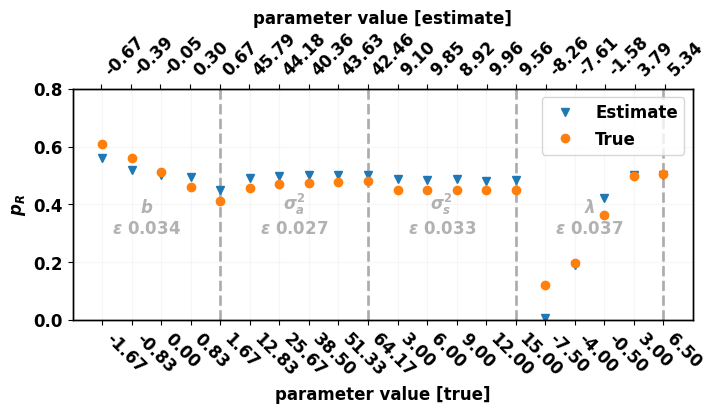

In [74]:
fig = plt.figure(figsize=(8,3))
plt.grid(alpha=0.1) 
plt.ylabel(f'$p_R$')
plt.xlabel('parameter value [true]')
plt.ylim([0,.8])
plt.xlim([-1, 20])
# plt vlines
plt.vlines(np.arange(4,20,5), 0, 1, colors='k', linestyles='--', lw=2, alpha=0.3)
# text align in center
plt.text(1.5, 0.3, f'$b$\n$\epsilon$ {error_parts[0]:.3f}', fontsize=12, ha='center', alpha=0.3)
plt.text(6.5, 0.3, f'$\sigma^2_a$\n$\epsilon$ {error_parts[1]:.3f}', fontsize=12, ha='center', alpha=0.3)
plt.text(11.5, 0.3, f'$\sigma^2_s$\n$\epsilon$ {error_parts[2]:.3f}', fontsize=12, ha='center', alpha=0.3)
plt.text(16.5, 0.3, f'$\lambda$\n$\epsilon$ {error_parts[3]:.3f}', fontsize=12, ha='center', alpha=0.3)

plt.plot(probR_estimate, 'v', label='Estimate', lw=2)
plt.plot(probR_true, 'o', label='True', lw=2)

# tick of x axis set as 0->20
xticks_label_array=np.array([all_thetas_dr[i, :, i].numpy() for i in range(4)]).reshape(-1)
# show 2 digits xtick label
xticks_label = [f'{x:4.2f}' for x in xticks_label_array]
plt.xticks(np.arange(20), xticks_label, rotation=-45, ha='left')

plt.legend()

# twinx
ax2 = plt.twiny()
# ax2.set_xlim(ax.get_xlim())
ax2.plot(np.arange(20), np.zeros(20), alpha=0)
xticks_label_array=np.array([theta_estimate[i, :, i] for i in range(4)]).reshape(-1)
xticks_label = [f'{x:4.2f}' for x in xticks_label_array]
ax2.set_xticks(np.arange(20), xticks_label, rotation=45, ha='left')
ax2.set_xlabel('parameter value [estimate]')

save_fig = fig_dir / 'npe' / f'{log_exp_id}-test-acc.png'
fig.savefig(save_fig, dpi=300, bbox_inches="tight", pad_inches=0)

### compare psy curve

In [196]:
fig_dir = Path(f"{NSC_DIR}/codes/notebook/figures/")
valid_data_dir = f"{fig_dir}/compare/dataset_varying_params.pt"
data = torch.load(valid_data_dir)
x_o = data["x_o"]
seqC_o = data["seqC_o"]
params = data["params"]
probR = data["probR"]
chR = data["chR"]
prior_labels = data["prior_labels"]
normed_limits = data["normed_limits"]
designed_limits = data["designed_limits"]
step = 7
nT = 28
num_params = 4
C_idx = 0
D, M, S = seqC_o.shape[0], seqC_o.shape[1], seqC_o.shape[2]
DMS = D * M * S

# map 3, 5, 7, 9, 11, 13, 15
chosen_dur_list = np.array([3, 9, 15])
chosen_dur_idx = ((chosen_dur_list - 3) / 2).astype(int)

x_o_chosen_dur = x_o[chosen_dur_idx].reshape(-1, 15)
x_o_all = x_o.reshape(-1, 15)
print(f"==>> x_o_chosen_dur.shape: {x_o_chosen_dur.shape}")
print(f"==>> x_o_all.shape: {x_o_all.shape}")

==>> x_o_chosen_dur.shape: torch.Size([6300, 15])
==>> x_o_all.shape: torch.Size([14700, 15])


In [213]:
from features.features import Feature_Generator
idx_C = 0
T = 0
features_true = []
for T in tqdm(range(nT)):
    if T % step == 0 or T % step == step - 1:
        continue
    chR_ = chR[:,:,:,T,idx_C]

    FG = Feature_Generator()
    FG.compute_kernels(seqC_o, chR_, D, M, S)
    feature_1s, feature_2s, feature_3s, feature_4s, feature_5s = FG.get_features()
    feature_5s_normed = convert_array_range(feature_5s, [-1, 1], [0, 1])
    features = [feature_1s, feature_2s, feature_3s, feature_4s, feature_5s_normed]
    # feature = FG.compute_kernels(seqC, chR, D, M, S).get_provided_feature(feature_list=[1,2,3,4,5])
    feature_lens = [x.shape[1] for x in features]

    feature = []
    for i in range(M):
        for j in range(len(features)):
            feature.append(features[j][i])
    feature = torch.cat(feature)
    features_true.append(feature)

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [00:13<00:00,  2.05it/s]


In [211]:
theta_estimate.shape

(4, 5, 4)

use same seqC simulate for estimated params

In [215]:
seqC_o.shape

torch.Size([7, 3, 700, 15])

In [217]:
theta_estimate_ = theta_estimate.reshape(-1, 4)

In [219]:
params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
    seqCs=seqC_o,
    prior=theta_estimate_,
    num_workers=16,
    privided_prior=True,
)


--- simulating pR with... ---
prior sample size: 1
model_name: B-G-L0S-O-N-
total number of simulations 294000 with 16 workers ...



/tmp/ipykernel_3748912/3506957865.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  params, probR = DM_sim_for_seqCs_parallel_with_smaller_output(
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=16)]: Done 352 tasks      | elapsed:    5.3s
[Parallel(n_jobs=16)]: Done 2352 tasks      | elapsed:   10.5s
[Parallel(n_jobs=16)]: Done 5152 tasks      | elapsed:   17.9s
[Parallel(n_jobs=16)]: Done 8752 tasks      | elapsed:   27.5s
[Parallel(n_jobs=16)]: Done 13152 tasks      | elapsed:   39.3s
[Parallel(n_jobs=16)]: Done 18352 tasks      | elapsed:   53.2s
[Parallel(n_jobs=16)]: Done 24352 tasks      | elapsed:  1.2min
[Parallel(n_jobs=16)]: Done 31152 tasks      | elapsed:  1.5min
[Parallel(n_jobs=16)]: Done 38752 tasks      | elapsed:  1.8min
[Parallel(n_jobs=16)]: Done 47152 tasks      | elapsed:  2.2

time elapsed for simulation: 13.69 minutes
stacking the results
done stacking the results

seqC.shape: torch.Size([7, 3, 700, 15]), params.shape: (20, 4), probR.shape: (7, 3, 700, 20, 1)


[Parallel(n_jobs=16)]: Done 294000 out of 294000 | elapsed: 13.7min finished


In [220]:
probR_estimate = torch.from_numpy(probR).float()
chR_estimate = probR_estimate.repeat_interleave(10, dim=-1)
chR_estimate = torch.bernoulli(chR_estimate)

In [222]:
idx_C = 0

features_estimate = []
for T in tqdm(range(20)):
    
    chR_ = chR_estimate[:,:,:,T,idx_C]

    FG = Feature_Generator()
    FG.compute_kernels(seqC_o, chR_, D, M, S)
    feature_1s, feature_2s, feature_3s, feature_4s, feature_5s = FG.get_features()
    feature_5s_normed = convert_array_range(feature_5s, [-1, 1], [0, 1])
    features = [feature_1s, feature_2s, feature_3s, feature_4s, feature_5s_normed]
    # feature = FG.compute_kernels(seqC, chR, D, M, S).get_provided_feature(feature_list=[1,2,3,4,5])
    feature_lens = [x.shape[1] for x in features]

    feature = []
    for i in range(M):
        for j in range(len(features)):
            feature.append(features[j][i])
    feature = torch.cat(feature)
    features_estimate.append(feature)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


In [223]:
torch.save(
    {
        "features_true": features_true,
        "features_estimate": features_estimate,
        "probR_estimate": probR_estimate,
        "chR_estimate": chR_estimate,
        "theta_estimate": theta_estimate,
    },
    f"{fig_dir}/compare/dataset_varying_params_features_estimate.pt",
)       

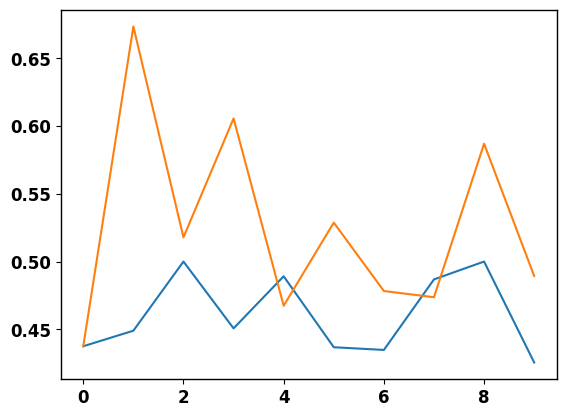

In [235]:
# plt.plot(features_true[0], label='true')
# plt.plot(features_estimate[0], label='estimate')

# plt.plot(features_true[1], label='true')
# plt.plot(features_estimate[1], label='estimate')

plt.plot(features_true[2][:10], label='true')
plt.plot(features_estimate[2][:10], label='estimate')

In [226]:
features_estimate[0]

tensor([0.6250, 0.4082, 0.6250, 0.6197, 0.5217, 0.6207, 0.6087, 0.5789, 0.5000,
        0.5957, 0.7222, 0.5909, 0.5312, 0.4921, 0.5930, 0.5952, 0.5980, 0.6495,
        0.5294, 0.6000, 0.6857, 0.8235, 0.4000, 0.5385, 0.5254, 0.5441, 0.5660,
        0.5636, 0.5816, 0.5833, 0.5965, 0.5806, 0.7778, 0.5000, 0.5152, 0.5435,
        0.6250, 0.5446, 0.5391, 0.5574, 0.5443, 0.5102, 0.5455, 0.6250, 0.4286,
        0.6522, 0.4528, 0.5534, 0.5583, 0.5691, 0.5405, 0.5169, 0.5476, 0.6842,
        0.6250, 0.0000, 0.6000, 0.5513, 0.6000, 0.5374, 0.5789, 0.6452, 0.4762,
        0.5000, 0.6058, 0.6250, 0.6095, 0.6167, 0.6000, 0.4286, 0.5000, 0.4000,
        0.5909, 0.6250, 0.0000, 0.6522, 0.5152, 0.5385, 0.5312, 0.4082, 0.6000,
        0.4528, 0.5435, 0.5254, 0.4921, 0.6250, 0.6058, 0.5513, 0.5534, 0.6250,
        0.5441, 0.5930, 0.6197, 0.6250, 0.6000, 0.5583, 0.5446, 0.5660, 0.5952,
        0.5217, 0.6095, 0.5374, 0.5691, 0.5391, 0.5636, 0.5980, 0.6207, 0.6167,
        0.5789, 0.5405, 0.5574, 0.5816, 

## [Quantitive] evaluate the performance of the trained model
on whole validation dataset </br>

In [ ]:
from utils.inference import samples_on_dset
samples_collection, thetas = samples_on_dset(posterior, valid_dataset)

save_npy = fig_dir / "npe" / f"{log_exp_id}-samples_collection.npy"
np.save(save_npy, samples_collection)
save_npy = fig_dir / "npe" / f"{log_exp_id}-thetas.npy"
np.save(save_npy, thetas)

In [ ]:
# xy, theta = valid_dataset[0]

# samples = sampling_from_posterior(
#     "cuda",
#     posterior,
#     xy,
#     num_samples=2000,
#     show_progress_bars=False,
# )

# fig, axes = plt.subplots(1, 4, figsize=(20, 4))
# fig.subplots_adjust(wspace=0.4)
# ax = marginal_plot(
#     samples,
#     theta,
#     origin_limits=normed_limits,
#     dest_limits=designed_limits,
#     moving_theta_idx=-1,
#     axes=axes,
#     credible_interval=20,
# )
# for i, x in enumerate(ax):
#     x.set_xlabel(prior_labels[i])

### ci [20, 50, 95]

In [49]:
prior_limits = solver._get_limits()

credible_intervals = [20, 50, 95]
ci = perfs_on_dset(
    samples_collection,
    thetas,
    credible_intervals,
    num_params,
    prior_limits,
    mode="ci",
)

save_npy = fig_dir / "npe" / f"{log_exp_id}-ci.npy"
np.save(save_npy, ci)

print(f"{log_exp_id}:\nci_valid\n", ci)

  4%|▎         | 747/20000 [00:00<00:15, 1222.78it/s]

100%|██████████| 20000/20000 [00:15<00:00, 1264.49it/s]

npe-conv_lstm-mdn:
ci_valid
 [[0.18835 0.12835 0.14455 0.17555]
 [0.4754  0.3811  0.3747  0.4448 ]
 [0.9242  0.88965 0.87945 0.91215]]


### mean prediction error

In [50]:
mse_mean, est_mean_s = perfs_on_dset(
    samples_collection,
    thetas,
    credible_intervals,
    num_params,
    prior_limits,
    mode="mean",
)

save_npy = fig_dir / "npe" / f"{log_exp_id}-mse_mean.npy"
np.save(save_npy, mse_mean)
save_npy = fig_dir / "npe" / f"{log_exp_id}-est_mean.npy"
np.save(save_npy, est_mean_s)

print(f"{log_exp_id} valid \nmean mse\n", mse_mean)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:01<00:00, 18118.49it/s]


npe-conv_lstm-mdn valid 
mean mse
 [0.01741236 0.07607137 0.08125174 0.0304651 ]


### median prediction error

In [53]:
mse_median, est_median_s = perfs_on_dset(
    samples_collection,
    thetas,
    credible_intervals,
    num_params,
    prior_limits,
    mode="median",
)

save_npy = fig_dir / "npe" / f"{log_exp_id}-mse_median.npy"
np.save(save_npy, mse_median)
save_npy = fig_dir / "npe" / f"{log_exp_id}-est_median.npy"
np.save(save_npy, est_median_s)

print(f"{log_exp_id} valid \nmedian mse\n", mse_median)

  6%|▋         | 1290/20000 [00:00<00:02, 6444.50it/s]

100%|██████████| 20000/20000 [00:03<00:00, 6425.19it/s]


npe-conv_lstm-mdn valid 
median mse
 [0.0174256  0.07610858 0.08129915 0.03117629]


### mode prediction error

In [54]:
mse_mode, est_mode_s = perfs_on_dset(
    samples_collection,
    thetas,
    credible_intervals,
    num_params,
    prior_limits,
    mode="mode",
)

save_npy = fig_dir / "npe-f" / f"{log_exp_id}-mse_mode.npy"
np.save(save_npy, mse_mode)
print('saved to', save_npy)
save_npy = fig_dir / "npe-f" / f"{log_exp_id}-est_mode.npy"
np.save(save_npy, est_mode_s)
print('saved to', save_npy)

print(f"{log_exp_id} valid \nmode mse\n", mse_mode)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [1:22:38<00:00,  4.03it/s]

saved to /home/wehe/tmp/NSC/codes/notebook/figures/npe-f/npe-conv_lstm-mdn-mse_mode.npy
saved to /home/wehe/tmp/NSC/codes/notebook/figures/npe-f/npe-conv_lstm-mdn-est_mode.npy
npe-conv_lstm-mdn valid 
mode mse
 [0.03176166 0.09143427 0.08317339 0.03675293]


### c2st

In [55]:
from sbi.utils.metrics import c2st
from utils.inference import my_c2st

In [56]:
num_C_valid_dataset = 25
# vstack thetas
thetas_true = torch.stack(thetas)
est_mode = torch.from_numpy(np.stack(est_mode_s))
est_mean = torch.from_numpy(np.stack(est_mean_s))
est_median = torch.from_numpy(np.stack(est_median_s))

# thetas_true = thetas_true[::num_C_valid_dataset]
# est_mode = est_mode[::num_C_valid_dataset]
# est_mean = est_mean[::num_C_valid_dataset]
# est_median = est_median[::num_C_valid_dataset]

In [60]:
num_params = 2
chosen_theta = [0, 3]
c2st_mode = my_c2st(
    thetas_true[:, chosen_theta],
    est_mode[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_mode: {c2st_mode}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:53<00:00,  1.86it/s]

==>> my_c2st_mode: 0.8086249828338623


In [61]:
num_params = 2
chosen_theta = [0, 3]
c2st_median = my_c2st(
    thetas_true[:, chosen_theta],
    est_median[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_median: {c2st_median}")

/home/wehe/tmp/NSC/codes/src/utils/inference.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.cat((torch.tensor(X_1), torch.tensor(X_0)), dim=0)
  2%|▏         | 2/100 [00:01<00:54,  1.81it/s]

100%|██████████| 100/100 [00:51<00:00,  1.92it/s]

==>> my_c2st_median: 0.7412499785423279


In [62]:
num_params = 2
chosen_theta = [0, 3]
c2st_mean = my_c2st(
    thetas_true[:, chosen_theta],
    est_mean[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_mean: {c2st_mean}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:52<00:00,  1.90it/s]

==>> my_c2st_mean: 0.7434999942779541


In [65]:
num_params = 3
chosen_theta = [0, 1, 3]
c2st_mode = my_c2st(
    thetas_true[:, chosen_theta],
    est_mode[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_mode: {c2st_mode}")

c2st_median = my_c2st(
    thetas_true[:, chosen_theta],
    est_median[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_median: {c2st_median}")

c2st_mean = my_c2st(
    thetas_true[:, chosen_theta],
    est_mean[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_mean: {c2st_mean}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


==>> my_c2st_mode: 0.9312499761581421


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


==>> my_c2st_median: 0.9403749704360962


100%|██████████| 100/100 [00:50<00:00,  1.96it/s]

==>> my_c2st_mean: 0.9202499985694885


In [66]:
num_params = 1
chosen_theta = [0]
c2st_mode = my_c2st(
    thetas_true[:, chosen_theta],
    est_mode[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_mode: {c2st_mode}")

c2st_median = my_c2st(
    thetas_true[:, chosen_theta],
    est_median[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_median: {c2st_median}")

c2st_mean = my_c2st(
    thetas_true[:, chosen_theta],
    est_mean[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_mean: {c2st_mean}")

100%|██████████| 100/100 [00:48<00:00,  2.04it/s]


==>> my_c2st_mode: 0.6176249980926514


100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


==>> my_c2st_median: 0.49962499737739563


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

==>> my_c2st_mean: 0.5911250114440918


In [67]:
num_params = 1
chosen_theta = [1]
c2st_mode = my_c2st(
    thetas_true[:, chosen_theta],
    est_mode[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_mode: {c2st_mode}")

c2st_median = my_c2st(
    thetas_true[:, chosen_theta],
    est_median[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_median: {c2st_median}")

c2st_mean = my_c2st(
    thetas_true[:, chosen_theta],
    est_mean[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_mean: {c2st_mean}")

100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


==>> my_c2st_mode: 0.7402499914169312


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


==>> my_c2st_median: 0.8318750262260437


100%|██████████| 100/100 [00:51<00:00,  1.96it/s]

==>> my_c2st_mean: 0.8511250019073486


In [69]:
num_params = 1
chosen_theta = [2]
c2st_mode = my_c2st(
    thetas_true[:, chosen_theta],
    est_mode[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_mode: {c2st_mode}")

c2st_median = my_c2st(
    thetas_true[:, chosen_theta],
    est_median[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_median: {c2st_median}")

c2st_mean = my_c2st(
    thetas_true[:, chosen_theta],
    est_mean[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_mean: {c2st_mean}")

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


==>> my_c2st_mode: 0.8847500085830688


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


==>> my_c2st_median: 0.9731249809265137


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]

==>> my_c2st_mean: 0.9786249995231628


In [ ]:
num_params = 1
chosen_theta = [3]
c2st_mode = my_c2st(
    thetas_true[:, chosen_theta],
    est_mode[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_mode: {c2st_mode}")

c2st_median = my_c2st(
    thetas_true[:, chosen_theta],
    est_median[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_median: {c2st_median}")

c2st_mean = my_c2st(
    thetas_true[:, chosen_theta],
    est_mean[:, chosen_theta],
    n_epochs=100,
    num_params=num_params,
)
print(f"==>> my_c2st_mean: {c2st_mean}")

100%|██████████| 100/100 [00:49<00:00,  2.03it/s]


==>> my_c2st_mode: 0.5861250162124634


100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


==>> my_c2st_median: 0.6290000081062317


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]

==>> my_c2st_mean: 0.6778749823570251
